In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
flag = True  # Set this flag as needed
name = "Preprocessed_Data.csv" if flag == True else "Mall_Customers.csv"
df = pd.read_csv(name)
if name == "Mall_Customers.csv":
    df = df.drop(columns=['CustomerID'])
    df['Genre'] = df['Genre'].map({'Male': 1, 'Female': 0})
    ss = StandardScaler()
    df[ df.columns ] = ss.fit_transform( df[ df.columns ] )
df

,Annual Income (k$),Annual Income (k$) Spending Score (1-100),Genre,Income_per_Age,Spending Score (1-100)
0,-1.738999,-1.077128,1,-1.010344,-0.434801
1,-1.738999,-0.801479,1,-1.089296,1.195704
2,-1.700830,-1.291084,0,-0.999291,-1.715913
3,-1.700830,-0.794041,0,-1.108862,1.040418
4,-1.662660,-1.035562,0,-1.263499,-0.395980
...,...,...,...,...,...
195,2.268791,2.814769,0,1.760854,1.118061
196,2.497807,0.210545,0,1.100820,-0.861839
197,2.497807,2.746513,1,2.295258,0.923953
198,2.917671,-0.254120,1,2.656214,-1.250054


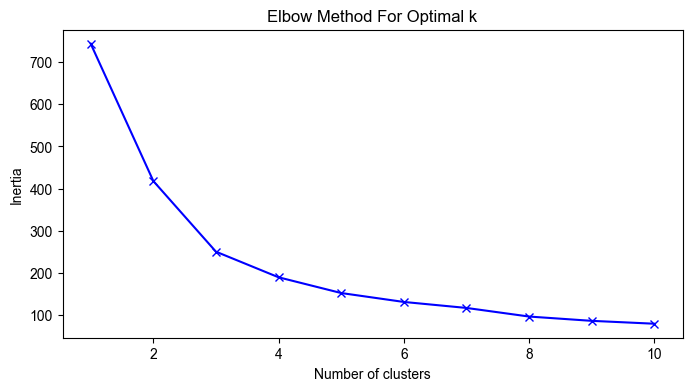

In [86]:
# get number of clusters using elbow method
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

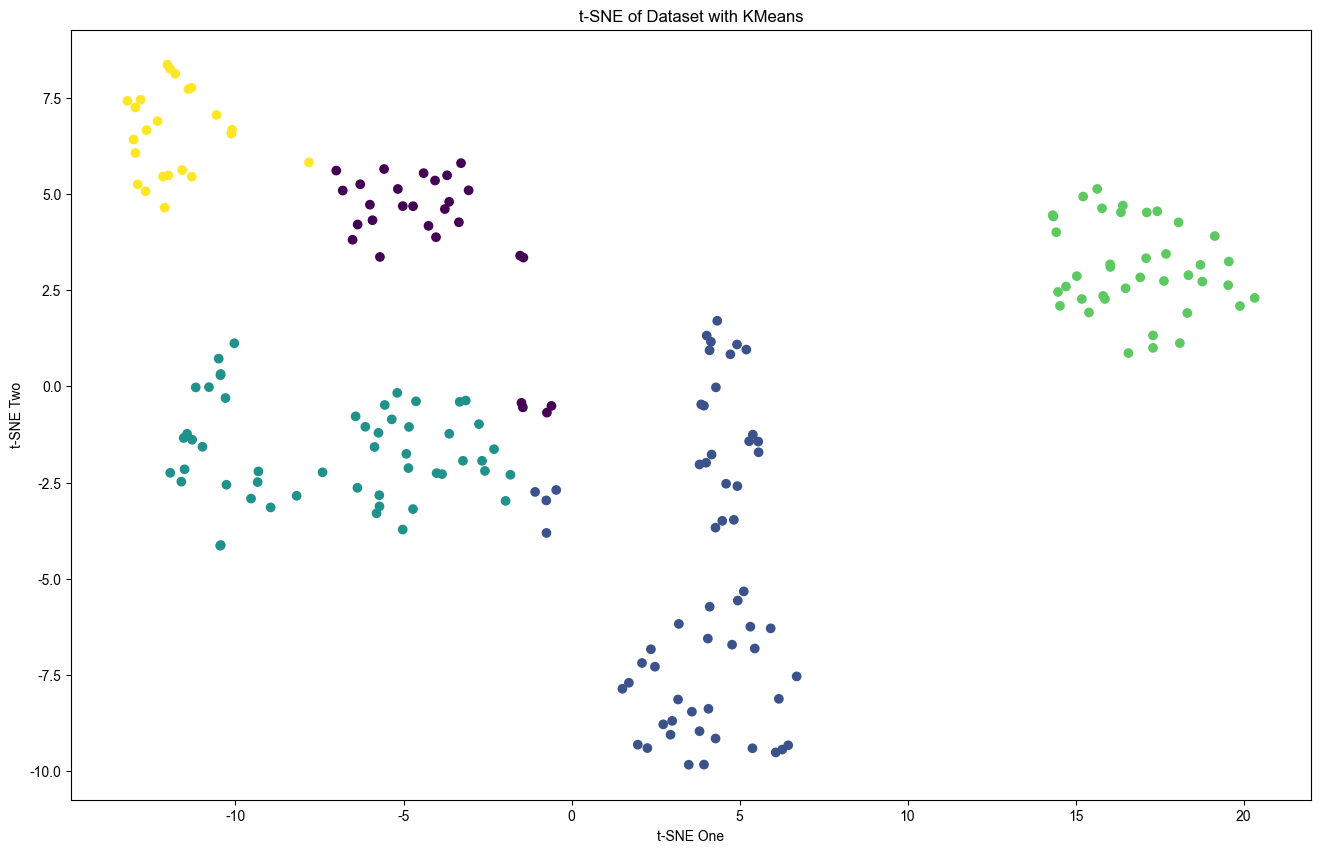

In [19]:
# Kmeans 聚类t-SNE降维结果
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

data_kmeans = df.copy() # already preprocessed
# apply clustering algorithm
Kmeans = KMeans(n_clusters=5, random_state=42)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_kmeans)
data_kmeans['tsne-one'] = tsne_result[:,0]
data_kmeans['tsne-two'] = tsne_result[:,1]
data_kmeans['cluster'] = Kmeans.fit_predict(data_kmeans[['tsne-one', 'tsne-two']])
plt.figure(figsize=(16,10))
plt.scatter(data_kmeans['tsne-one'], data_kmeans['tsne-two'], c=data_kmeans['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE of Dataset with KMeans')
plt.show()

In [6]:
# Evaluation By Silhouette Coef and Calinski-harabasz
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def evaluate_clustering(predicted_labels, data):
    # Filter out noise points (labeled as -1) for silhouette score calculation
    if -1 in predicted_labels:
        non_noise_indices = (predicted_labels != -1)
        if np.sum(non_noise_indices) > 1: # Silhouette score requires at least 2 labels
            silhouette = silhouette_score(data[non_noise_indices], predicted_labels[non_noise_indices])
            chs = calinski_harabasz_score(data[non_noise_indices], predicted_labels[non_noise_indices])
        else:
            silhouette = -1 # Not enough points to calculate
            chs = -1
    else:
        silhouette = silhouette_score(data, predicted_labels)
        chs = calinski_harabasz_score(data, predicted_labels)
    return silhouette, chs

,Annual Income (k$),Annual Income (k$) Spending Score (1-100),Genre,Income_per_Age,Spending Score (1-100)
kmedoids_cluster,,,,,
0,-0.533,-0.250,0.372,-0.598,0.240
1,0.883,-0.543,0.477,0.745,-1.081
2,1.294,2.165,0.318,1.299,1.356
3,0.299,0.846,0.769,0.640,0.873
4,-1.330,-1.103,0.364,-1.206,-1.164



=== 聚类评估指标 ===
轮廓系数: 0.3056
Calinski-Harabasz指数: 110.03


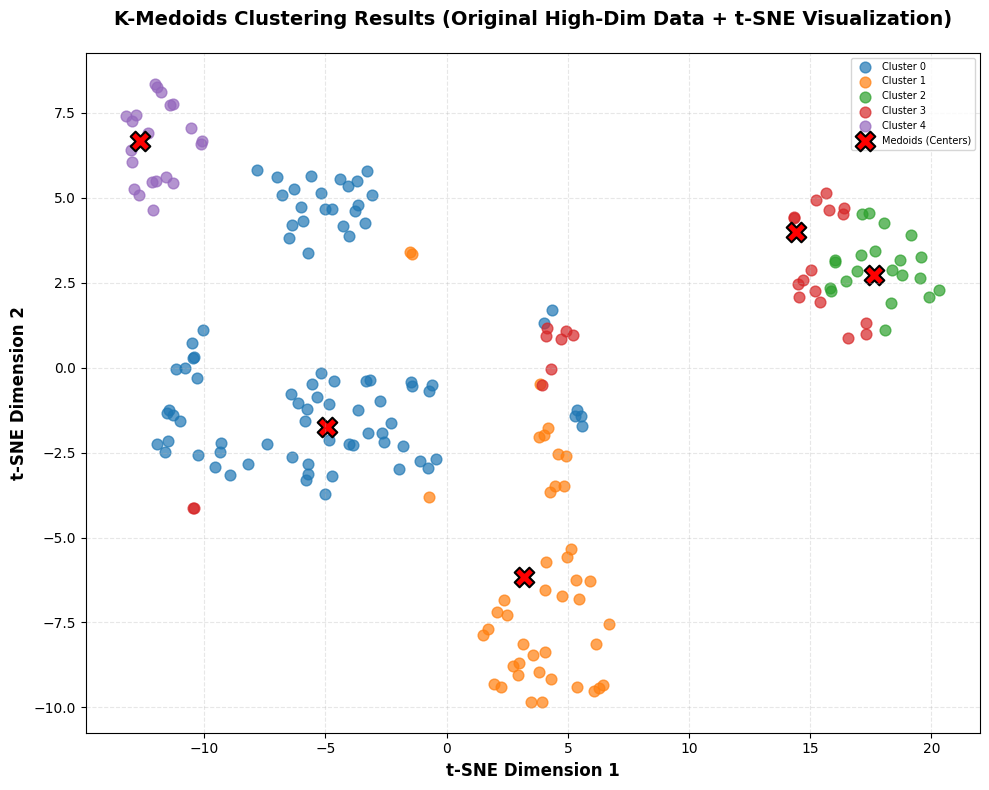

In [58]:
# clustering by k-medoids (PAM) - pure-Python implementation to avoid sklearn_extra binary dependency
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
import numpy as np

def kmedoids_pam(X, n_clusters, max_iter=300, random_state=42, metric='euclidean'):
    """PAM (Partitioning Around Medoids) with KMeans++-style initialization."""
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]
    # full pairwise distance matrix (Euclidean)
    D = pairwise_distances(X, metric=metric)

    def init_medoids_kpp(D, k, rng):
        """KMeans++-like initialization for medoids using distance matrix D."""
        n = D.shape[0]
        medoids = []
        # pick first medoid uniformly
        first = int(rng.integers(0, n))
        medoids.append(first)
        # pick remaining medoids
        for _ in range(1, k):
            # distance from each point to the nearest chosen medoid
            dist_to_nearest = np.min(D[:, medoids], axis=1)
            # squared distances (kmeans++ uses squared distances)
            probs = dist_to_nearest ** 2
            total = probs.sum()
            if total <= 0:
                # all distances zero -> pick randomly among remaining
                candidates = [i for i in range(n) if i not in medoids]
                if not candidates:
                    break
                next_medoid = int(rng.choice(candidates))
            else:
                probs = probs / total
                probs[medoids] = 0.0
                psum = probs.sum()
                if psum <= 0:
                    candidates = [i for i in range(n) if i not in medoids]
                    next_medoid = int(rng.choice(candidates))
                else:
                    next_medoid = int(rng.choice(n, p=probs))
            medoids.append(next_medoid)
        return np.array(medoids, dtype=int)

    # initialize medoids with kmeans++-like method
    medoids = init_medoids_kpp(D, n_clusters, rng)
    labels = np.argmin(D[:, medoids], axis=1)

    for _ in range(max_iter):
        changed = False
        for i in range(n_clusters):
            cluster_idx = np.where(labels == i)[0]
            if len(cluster_idx) == 0:
                continue
            # compute total distance for each candidate medoid inside the cluster
            subD = D[np.ix_(cluster_idx, cluster_idx)]
            costs = subD.sum(axis=1)
            new_medoid_local = cluster_idx[np.argmin(costs)]
            if new_medoid_local != medoids[i]:
                medoids[i] = new_medoid_local
                changed = True
        new_labels = np.argmin(D[:, medoids], axis=1)
        if not changed and np.all(labels==new_labels):
            break
        labels = new_labels
    return medoids, labels

# prepare data and run K-Medoids on 2D PCA projection
data_kmedoids = df.copy()  # already preprocessed
kmedoids_n = 5

X = data_kmedoids.copy()
medoids, labels = kmedoids_pam(
    X=X, 
    n_clusters=kmedoids_n, 
    random_state=42
)
# 5. Analyze the mean of the clusters
data_kmedoids['kmedoids_cluster'] = labels
cluster_stats = data_kmedoids.groupby('kmedoids_cluster').mean().round(3)
display(cluster_stats)


# 可视化之前，先把聚类标签从数据中删去，避免影响t-SNE结果
data_kmedoids = data_kmedoids.drop(columns=['kmedoids_cluster'])

print("\n=== 聚类评估指标 ===")
# 轮廓系数（越接近1越好，衡量簇内紧凑度与簇间分离度）
sil_score, chs_score = evaluate_clustering(labels, data_kmedoids)
# Calinski-Harabasz指数（越大越好，衡量簇间方差/簇内方差比）
print(f"轮廓系数: {sil_score:.4f}")
print(f"Calinski-Harabasz指数: {chs_score:.2f}")

# 6. t-SNE降维可视化（仅用于展示，不影响聚类结果）

# 对原始高维数据做t-SNE降维（映射到2D）
tsne = TSNE(n_components=2, random_state=42) 
tsne_result = tsne.fit_transform(data_kmedoids)

# 合并t-SNE结果与聚类标签
tsne_df = pd.DataFrame({
    't-SNE_1': tsne_result[:, 0],
    't-SNE_2': tsne_result[:, 1],
    'Cluster_Label': labels
})

# 绘制t-SNE聚类可视化图
plt.figure(figsize=(10, 8))
# 绘制各簇样本点
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'yellow', 'brown']  # 5簇配色，可扩展
for label in range(kmedoids_n):
    mask = tsne_df['Cluster_Label'] == label
    plt.scatter(
        tsne_df.loc[mask, 't-SNE_1'],
        tsne_df.loc[mask, 't-SNE_2'],
        c=colors[label],
        label=f'Cluster {label}',
        alpha=0.7,
        s=60
    )

# 标记K-Medoids质心（在t-SNE空间中的位置）
medoids_tsne = tsne_result[medoids]  # 质心的t-SNE坐标
plt.scatter(
    medoids_tsne[:, 0],
    medoids_tsne[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Medoids (Centers)',
    edgecolors='black',
    linewidth=1.5
)

# 图表美化与标签
plt.xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
plt.title('K-Medoids Clustering Results (Original High-Dim Data + t-SNE Visualization)', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=7, loc='upper right')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [59]:
# 假设已生成tsne_result（t-SNE降维结果）和df_scaled（标准化后的原始特征）
# 1. 构建t-SNE维度与原始特征的关联数据集
tsne_features = pd.DataFrame(tsne_result, columns=['t-SNE_1', 't-SNE_2'])
# 合并原始标准化特征
corr_df = pd.concat([data_kmedoids.reset_index(drop=True), tsne_features.reset_index(drop=True)], axis=1)

# 2. 计算原始特征与t-SNE维度的皮尔逊相关系数（核心：量化特征贡献）
correlation_matrix = corr_df.corr()[['t-SNE_1', 't-SNE_2']].round(3)
print("=== 原始特征与t-SNE维度的相关系数 ===")
display(correlation_matrix)

# 示例解读：若"Annual Income (k$)"与t-SNE_1的相关系数为0.8，说明t-SNE_1主要反映年收入的差异

=== 原始特征与t-SNE维度的相关系数 ===


,t-SNE_1,t-SNE_2
Annual Income (k$),0.824,-0.352
Annual Income (k$) Spending Score (1-100),0.808,0.265
Genre,0.066,0.167
Income_per_Age,0.814,-0.336
Spending Score (1-100),0.359,0.317
t-SNE_1,1.000,-0.092
t-SNE_2,-0.092,1.000


In [46]:
# K-medoids 调参 By Grid Search
param_grid = {
    'n_clusters': [3, 4, 5, 6, 7, 8, 9],          # 簇数：初次选取3，新增4~6验证业务可解释性
    'max_iter': [300, 500, 800],      # 迭代次数：原文为300，新增500/800确保收敛
    'metric': ['euclidean', 'manhattan']  # 距离度量：原文为欧氏，新增曼哈顿（抗异常值）
}
res = []

for n_clusters in param_grid['n_clusters']:
    for max_iter in param_grid['max_iter']:
        for metric in param_grid['metric']:
            # 运行K-Medoids聚类
            meds, lbs = kmedoids_pam(
                X=X,
                n_clusters=n_clusters,
                max_iter=max_iter,
                random_state=42,
                metric=metric
            )
            silhouette, CHS = evaluate_clustering(lbs, X)
            res.append({
                'n_clusters': n_clusters,
                'max_iter': max_iter,
                'metric': metric,
                'silhouette_score': silhouette,
                'calinski_harabasz_score': CHS,
                'medoids': meds,
                'labels': lbs
            })

results_df = pd.DataFrame(res)
# 按silhouette score 降序排列
best_param = results_df.sort_values('silhouette_score', ascending=False).iloc[0]
print("=== K-Medoids 最优超参组合 ===")
print(f"簇数 (n_clusters): {best_param['n_clusters']}")
print(f"最大迭代次数 (max_iter): {best_param['max_iter']}")
print(f"距离度量 (metric): {best_param['metric']}")
print(f"轮廓系数 (Silhouette): {best_param['silhouette_score']:.4f}")
print(f"Calinski-Harabasz指数: {best_param['calinski_harabasz_score']:.2f}")
# results_df
# best_param

=== K-Medoids 最优超参组合 ===
簇数 (n_clusters): 3
最大迭代次数 (max_iter): 300
距离度量 (metric): euclidean
轮廓系数 (Silhouette): 0.3370
Calinski-Harabasz指数: 135.72


,n_clusters,silhouette_score,calinski_harabasz_score
0,3,0.336961,135.715143
1,4,0.303495,115.642462
2,5,0.305595,110.028952
3,6,0.290901,96.630027
4,7,0.232159,94.660568
5,8,0.224805,87.298971
6,9,0.331143,108.298606


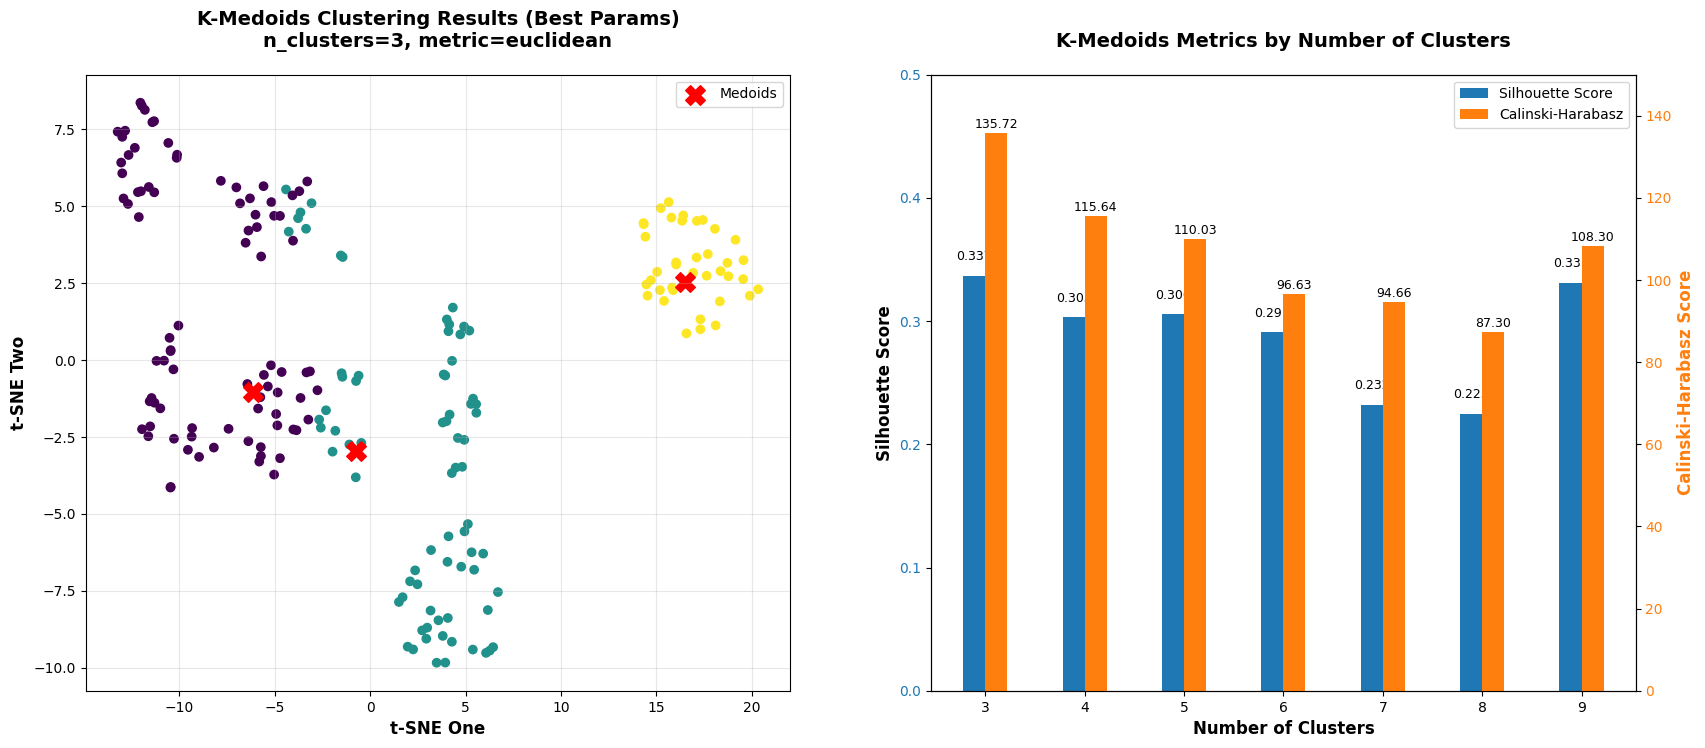

In [60]:
# 7.1 子图1：聚类散点图（按簇着色）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))  # 双图布局：散点图+指标对比


tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_kmedoids)
data_vis = pd.DataFrame({
    'tsne-one': tsne_result[:,0],
    'tsne-two': tsne_result[:,1],
    'Cluster': best_param['labels']
})

# 绘制样本点（按簇着色）
scatter = ax1.scatter(data_vis['tsne-one'], data_vis['tsne-two'], c=best_param['labels'])
# 标记质心（红色X，突出显示）
ax1.scatter(data_vis['tsne-one'][best_param['medoids']], data_vis['tsne-two'][best_param['medoids']], c='red', marker='X', s=200, label='Medoids')
# 图表样式（与原文一致）
ax1.set_xlabel('t-SNE One', fontsize=12, fontweight='bold')
ax1.set_ylabel('t-SNE Two', fontsize=12, fontweight='bold')
ax1.set_title(f'K-Medoids Clustering Results (Best Params)\nn_clusters={best_param["n_clusters"]}, metric={best_param["metric"]}', 
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 7.2 子图2：不同簇数的指标对比（辅助业务决策）
cluster_metrics = results_df.groupby('n_clusters').agg(
    {'silhouette_score': 'max','calinski_harabasz_score': 'max'}
).reset_index()

# 双轴图：左轴=轮廓系数，右轴=Calinski-Harabasz
ax2_twin = ax2.twinx()
width = 0.4;     gap = 1.0
x_coords = np.arange(len(cluster_metrics['n_clusters'])) * (width * 2 + gap)
bar1 = ax2.bar(
    x_coords - width / 2, cluster_metrics['silhouette_score'],
    width=width, label='Silhouette Score', color='#1f77b4'
)
bar2 = ax2_twin.bar(
    x_coords + width / 2, cluster_metrics['calinski_harabasz_score'],  # 缩放以便同图显示
    width=width, label='Calinski-Harabasz', color='#ff7f0e'
)
# 图表样式
ax2.set_xlabel('Number of Clusters', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_ybound(0, 0.5)
ax2_twin.set_ylabel('Calinski-Harabasz Score', fontsize=12, fontweight='bold', color='#ff7f0e')
ax2_twin.set_ybound(0, 150)
ax2.set_title('K-Medoids Metrics by Number of Clusters', fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x_coords)
ax2.set_xticklabels(cluster_metrics['n_clusters'])
ax2.tick_params(axis='y', labelcolor='#1f77b4')
ax2_twin.tick_params(axis='y', labelcolor='#ff7f0e')
# 添加数值标签
for bar in bar1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bar2:
    height = bar.get_height()
    ax2_twin.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                  f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# 合并图例
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='upper right')

display(cluster_metrics)

# # 8. 保存结果（可选：保存最优参数的聚类标签到原数据集）
# data_kmedoids['kmedoids_cluster_best'] = best_param['labels']  # 新增最优聚类标签列
# data_kmedoids.to_csv('KMedoids_Best_Clustering_Result.csv', index=False)  # 保存结果到CSV
# plt.tight_layout()
# plt.savefig('KMedoids_Hyperparameter_Tuning_Result.png', dpi=300, bbox_inches='tight')  # 保存可视化图
# plt.show()

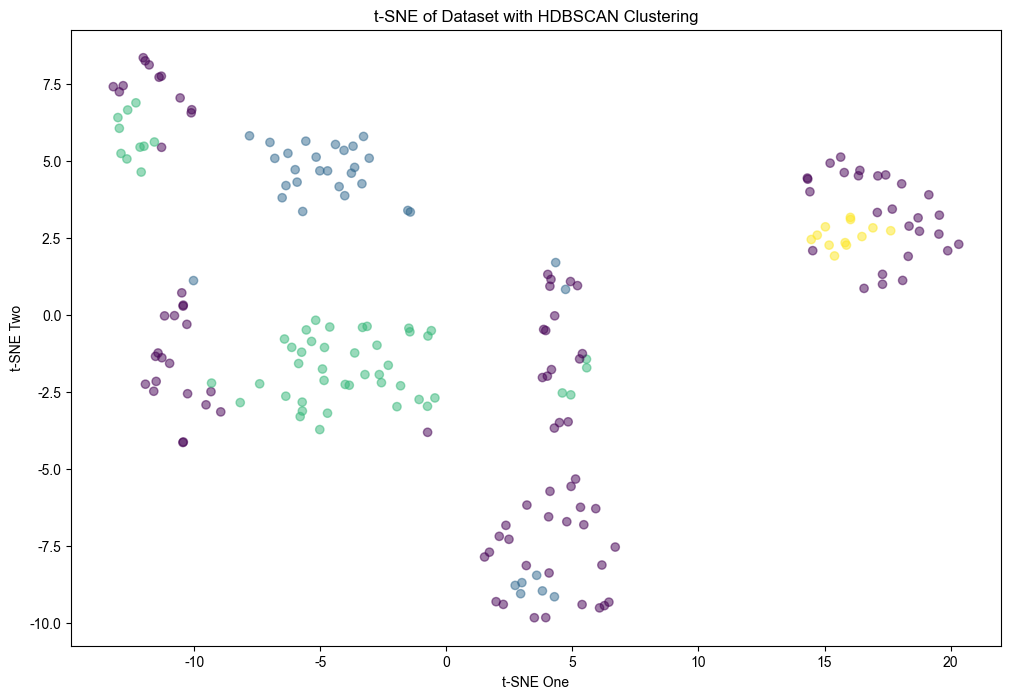

In [127]:
from sklearn.cluster import HDBSCAN
# import tSNE
from sklearn.manifold import TSNE
hdbscan_model = HDBSCAN(min_cluster_size=10)
data_hdbscan = df.copy() # already preprocessed
data_hdbscan_safety = data_hdbscan.copy()
hdbscan_results = hdbscan_model.fit_predict(data_hdbscan)

# apply clustering algorithm
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result_hdbscan = tsne.fit_transform(data_hdbscan)
# data_hdbscan['tsne-one'] = tsne_result_hdbscan[:,0]
# data_hdbscan['tsne-two'] = tsne_result_hdbscan[:,1]
data_hdbscan_vis = pd.DataFrame({
    'tsne-one': tsne_result_hdbscan[:,0],
    'tsne-two': tsne_result_hdbscan[:,1],
    'cluster': hdbscan_results
})

def evaluate_noise(predicted_labels, data):
    n_clusters = len(set(predicted_labels) - {-1})
    noise_ratio = np.sum(predicted_labels == -1) / len(predicted_labels)
    return n_clusters, noise_ratio

plt.figure(figsize=(12,8))
plt.scatter(data_hdbscan_vis['tsne-one'], data_hdbscan_vis['tsne-two'], alpha=0.5, c=data_hdbscan_vis['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE of Dataset with HDBSCAN Clustering')
plt.show()

In [133]:
# 4. HDBSCAN超参网格搜索（核心：遍历关键参数组合）
param_grid = {
    'min_cluster_size': [10, 15, 20, 25],  # 最小簇规模（重点调整）
    'min_samples': [5, 10, 15],            # 核心点邻域样本数
    'cluster_selection_epsilon': [1.0, 1.5, 2.0],  # 簇距离阈值
    'cluster_selection_method': ['eom'],   # 簇选择策略（默认eom更稳定）
    'metric': ['euclidean', 'manhattan']   # 距离度量
}

# 存储所有参数组合的结果
search_results = []

# 遍历参数网格
for min_cluster in param_grid['min_cluster_size']:
    for min_samp in param_grid['min_samples']:
        # 确保min_samples ≤ min_cluster_size（逻辑合理）
        if min_samp > min_cluster:
            continue
        for eps in param_grid['cluster_selection_epsilon']:
            for method in param_grid['cluster_selection_method']:
                for metric in param_grid['metric']:
                    # 初始化HDBSCAN模型
                    hdbscan_model = HDBSCAN(
                        min_cluster_size=min_cluster,
                        min_samples=min_samp,
                        cluster_selection_epsilon=eps,
                        cluster_selection_method=method,
                        metric=metric
                    )
                    # 基于原始高维数据聚类（核心：不依赖降维）
                    cluster_labels = hdbscan_model.fit_predict(data_hdbscan.values)
                    # 评估聚类效果
                    sil_score, chs_score = evaluate_clustering(cluster_labels, data_hdbscan.values)
                    n_clusters, noise_ratio = evaluate_noise(cluster_labels, data_hdbscan.values)
                    # 存储结果
                    search_results.append({
                        'min_cluster_size': min_cluster,
                        'min_samples': min_samp,
                        'cluster_selection_epsilon': eps,
                        'cluster_selection_method': method,
                        'metric': metric,
                        'silhouette_score': sil_score,
                        'calinski_harabasz_score': chs_score,
                        'n_clusters': n_clusters,
                        'noise_ratio': noise_ratio,
                        'cluster_labels': cluster_labels
                    })

# 转换为DataFrame便于查看
results_df = pd.DataFrame(search_results)
# 筛选有效结果（排除无有效簇的情况）
valid_results = results_df[results_df['n_clusters'] > 1].copy()
# valid_results

In [135]:
# 5. 选择最优超参数（优先轮廓系数最高）
# 按轮廓系数降序排列，取前5个候选
top_candidates = valid_results.sort_values('silhouette_score', ascending=False).head(10)
best_candidate = top_candidates.iloc[0]
# # 打印最优参数信息
print("=== HDBSCAN最优超参数组合 ===")
print(f"最小簇规模 (min_cluster_size): {best_candidate['min_cluster_size']}")
print(f"核心点邻域样本数 (min_samples): {best_candidate['min_samples']}")
print(f"簇距离阈值 (cluster_selection_epsilon): {best_candidate['cluster_selection_epsilon']}")
print(f"簇选择策略 (cluster_selection_method): {best_candidate['cluster_selection_method']}")
print(f"距离度量 (metric): {best_candidate['metric']}")
print(f"\n聚类评估指标:")
print(f"轮廓系数: {best_candidate['silhouette_score']:.4f}")
print(f"Calinski-Harabasz指数: {best_candidate['calinski_harabasz_score']:.2f}")
print(f"有效簇数: {best_candidate['n_clusters']}")
print(f"噪声占比: {best_candidate['noise_ratio']:.2%}")

=== HDBSCAN最优超参数组合 ===
最小簇规模 (min_cluster_size): 10
核心点邻域样本数 (min_samples): 10
簇距离阈值 (cluster_selection_epsilon): 2.0
簇选择策略 (cluster_selection_method): eom
距离度量 (metric): manhattan

聚类评估指标:
轮廓系数: 0.4532
Calinski-Harabasz指数: 84.02
有效簇数: 2
噪声占比: 31.00%


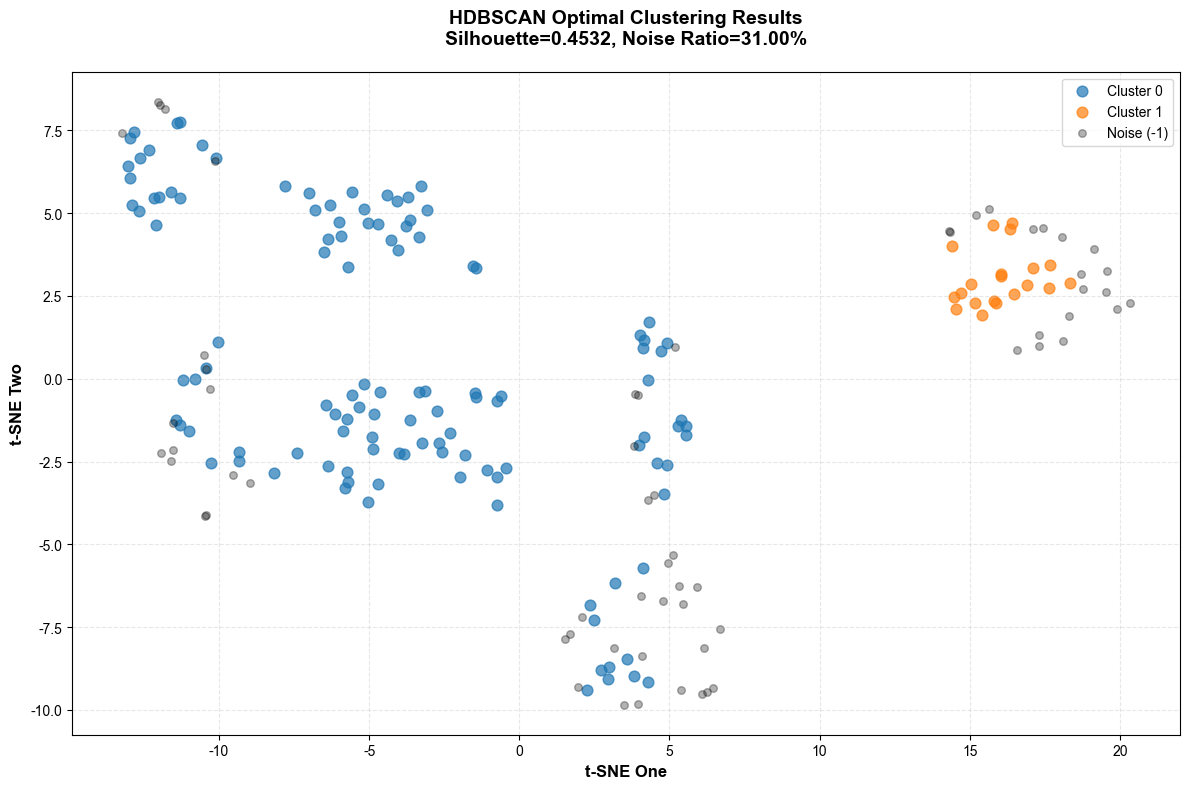

In [130]:
# 6. 最优结果可视化（原始数据聚类 + t-SNE降维展示）
# t-SNE降维（仅用于可视化，不影响聚类结果）
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(data_hdbscan.values)

# 构建可视化数据（合并t-SNE坐标与最优标签）
vis_df = pd.DataFrame({
    't-SNE One': tsne_result[:, 0],
    't-SNE Two': tsne_result[:, 1],
    'Cluster': best_candidate['cluster_labels']
})

# 绘制聚类散点图（噪声点用黑色标记）
plt.figure(figsize=(12, 8))
# 绘制有效簇（排除噪声）
for cluster in set(vis_df['Cluster']) - {-1}:
    mask = vis_df['Cluster'] == cluster
    plt.scatter(
        vis_df.loc[mask, 't-SNE One'],
        vis_df.loc[mask, 't-SNE Two'],
        alpha=0.7,
        s=60,
        label=f'Cluster {cluster}'
    )
# 绘制噪声点（黑色，透明度降低）
noise_mask = vis_df['Cluster'] == -1
plt.scatter(
    vis_df.loc[noise_mask, 't-SNE One'],
    vis_df.loc[noise_mask, 't-SNE Two'],
    c='black',
    alpha=0.3,
    s=30,
    label='Noise (-1)'
)

# 图表样式
plt.xlabel('t-SNE One', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Two', fontsize=12, fontweight='bold')
plt.title(
    f'HDBSCAN Optimal Clustering Results\nSilhouette={best_candidate["silhouette_score"]:.4f}, Noise Ratio={best_candidate["noise_ratio"]:.2%}',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [87]:
# BIC analysis: determine the best interval of n_components for GMM
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
data_for_BIC = df.copy()
X_for_BIC = data_for_BIC.copy()
# tsne_res_for_BIC = tsne.fit_transform(data_for_BIC)
# data_for_BIC['tsne-one'] = tsne_res_for_BIC[:,0]
# data_for_BIC['tsne-two'] = tsne_res_for_BIC[:,1]
# X_for_BIC = data_for_BIC[['tsne-one', 'tsne-two']].values

# 2.1 超参设置：固定其他超参为合理默认值，仅遍历n_components
fixed_cov_type = 'full'  # 先固定为默认全协方差（后续再扩展分析）
fixed_max_iter = 500     # 确保收敛的迭代次数
fixed_tol = 1e-3         # 默认收敛阈值
n_components_range = range(2, 11)  # 初步遍历2-10个聚类（覆盖业务常用范围）

bic_results_ncomp = []
for n_comp in n_components_range:
    gmm = GaussianMixture(
        n_components=n_comp,
        covariance_type=fixed_cov_type,
        max_iter=fixed_max_iter,
        tol=fixed_tol,
        random_state=42,
        init_params='kmeans'
    )
    gmm.fit(X_for_BIC)  # 拟合模型（BIC需基于拟合结果计算）
    bic_score = gmm.bic(X_for_BIC)  # 计算当前超参的BIC值
    bic_results_ncomp.append({
        'n_components': n_comp,
        'covariance_type': fixed_cov_type,
        'bic_score': bic_score
    })
# 转换为DataFrame便于处理
bic_df_ncomp = pd.DataFrame(bic_results_ncomp)
# 找出BIC最小的n_components（最优值）和对应的区间（±1范围，确保后续网格搜索覆盖）
best_ncomp = bic_df_ncomp.loc[bic_df_ncomp['bic_score'].idxmin(), 'n_components']
best_ncomp_range = [max(2, best_ncomp - 2), min(10, best_ncomp + 2)]  # 锁定最优区间（避免超出范围）
print(f"=== BIC分析结果(固定cov_type={fixed_cov_type})===")
print(f"BIC最小对应的最优n_components:{int(best_ncomp)}")
print(f"后续网格搜索建议n_components区间:{best_ncomp_range[0]}~{best_ncomp_range[1]}\n")
display(bic_df_ncomp)

=== BIC分析结果(固定cov_type=full)===
BIC最小对应的最优n_components:8
后续网格搜索建议n_components区间:6~10



,n_components,covariance_type,bic_score
0,2,full,1807.235137
1,3,full,1475.031506
2,4,full,1428.040861
3,5,full,1214.585776
4,6,full,1000.907818
5,7,full,1039.834562
6,8,full,341.522075
7,9,full,381.835645
8,10,full,425.051419


In [88]:
# BIC extension-- evaluate the effect of covariance_type
cov_types = ['full', 'tied', 'diag', 'spherical']
bic_results_cov = []
for cov_type in cov_types:
    for n_comp in n_components_range:
        gmm = GaussianMixture(
            n_components=n_comp,
            covariance_type=cov_type,
            max_iter=fixed_max_iter,
            tol=fixed_tol,
            random_state=42
        )
        gmm.fit(X_for_BIC)
        bic_score = gmm.bic(X_for_BIC)
        bic_results_cov.append({
            'n_components': n_comp,
            'covariance_type': cov_type,
            'bic_score': bic_score
        })
bic_df_cov = pd.DataFrame(bic_results_cov)
# Find the best n_components under every type of covariance matrix（验证区间一致性）
best_ncomp_per_cov = bic_df_cov.groupby('covariance_type').apply(
    lambda x: x.loc[x['bic_score'].idxmin(), 'n_components']
).reset_index()
best_ncomp_per_cov.columns = ['covariance_type', 'best_n_components']
display(best_ncomp_per_cov)
print("经验证，不同类型协方差对应的最佳n_components表现出较高一致性。")

C:\Users\18469\AppData\Local\Temp\ipykernel_6640\2386341529.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_ncomp_per_cov = bic_df_cov.groupby('covariance_type').apply(


,covariance_type,best_n_components
0,diag,6
1,full,8
2,spherical,10
3,tied,10


经验证，不同类型协方差对应的最佳n_components表现出较高一致性。


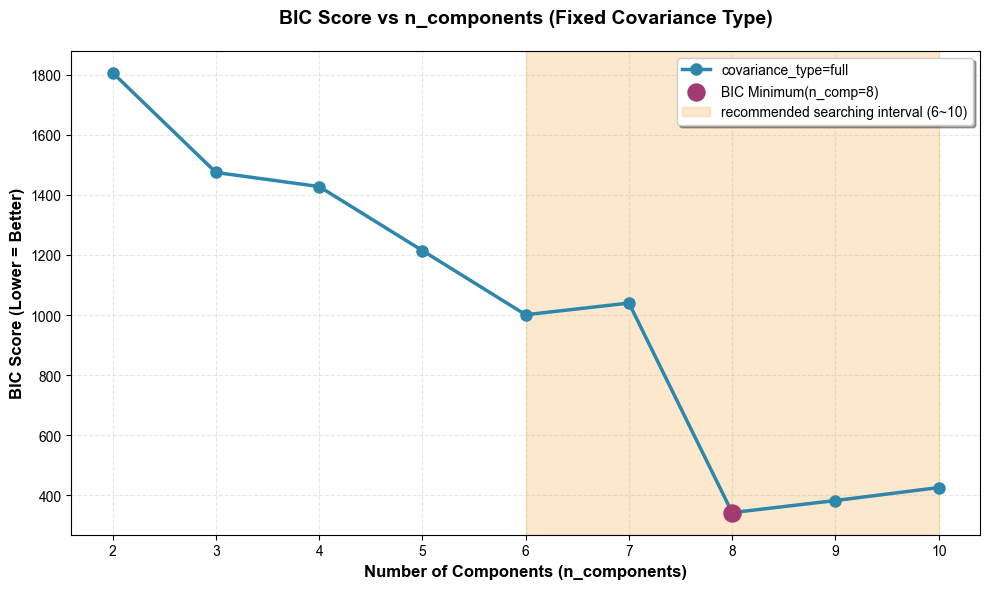

In [89]:
# BIC result visualization
plt.rcParams['font.sans-serif'] = ['Arial']  # 统一字体（避免乱码）
plt.rcParams['axes.unicode_minus'] = False

# 4.1 图1：固定cov_type下n_components与BIC的关系（核心区间分析）
plt.figure(figsize=(10, 6))
# 绘制BIC趋势线（带标记点）
plt.plot(
    bic_df_ncomp['n_components'], 
    bic_df_ncomp['bic_score'], 
    marker='o', 
    linewidth=2.5, 
    markersize=8, 
    color='#2E86AB', 
    label=f'covariance_type={fixed_cov_type}'
)
# 标记BIC最小值点
best_bic_score = bic_df_ncomp.loc[bic_df_ncomp['n_components'] == best_ncomp, 'bic_score'].values[0]
plt.scatter(
    best_ncomp, 
    best_bic_score, 
    color='#A23B72', 
    s=150, 
    zorder=5, 
    label=f'BIC Minimum(n_comp={int(best_ncomp)})'
)
# 标记最优区间（背景色高亮）
plt.axvspan(
    best_ncomp_range[0], 
    best_ncomp_range[1], 
    alpha=0.2, 
    color='#F18F01', 
    label=f'recommended searching interval ({best_ncomp_range[0]}~{best_ncomp_range[1]})'
)
# 图表美化
plt.xlabel('Number of Components (n_components)', fontsize=12, fontweight='bold')
plt.ylabel('BIC Score (Lower = Better)', fontsize=12, fontweight='bold')
plt.title('BIC Score vs n_components (Fixed Covariance Type)', fontsize=14, fontweight='bold', pad=20)
plt.xticks(n_components_range, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)
plt.tight_layout()
plt.show()

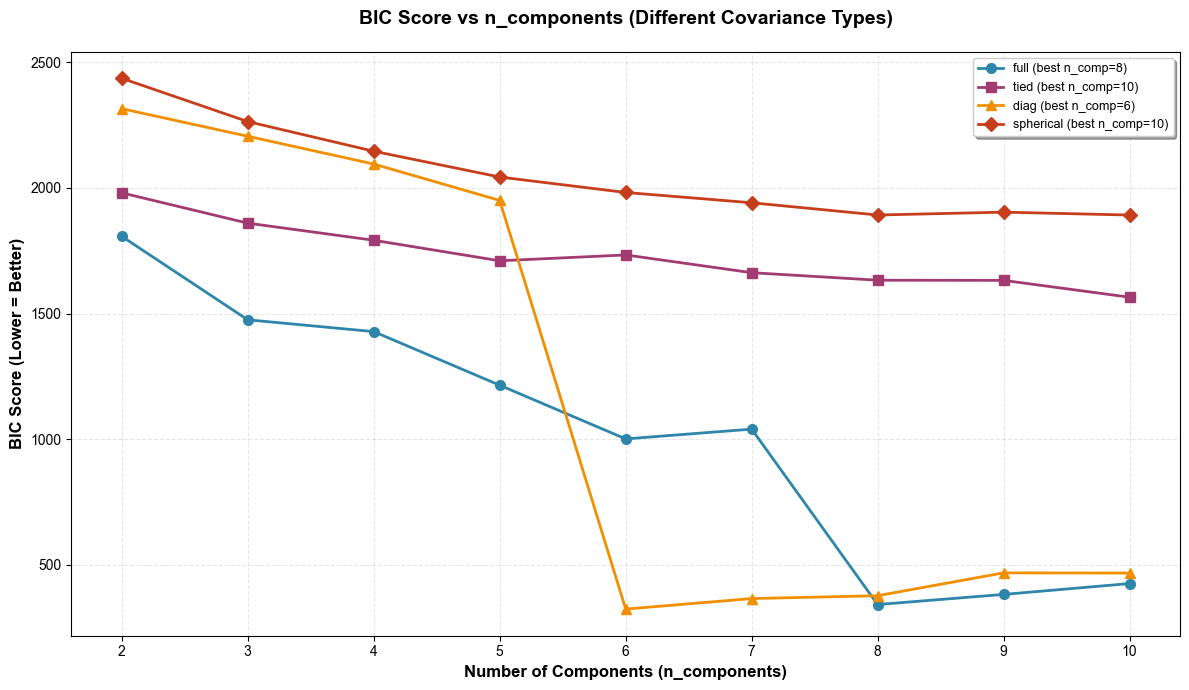

In [90]:
# 4.2 图2：不同cov_type下n_components与BIC的对比（扩展分析）
plt.figure(figsize=(12, 7))
# 为每种协方差类型设置不同颜色和标记
color_map = {'full': '#2E86AB', 'tied': '#A23B72', 'diag': '#F18F01', 'spherical': '#C73E1D'}
marker_map = {'full': 'o', 'tied': 's', 'diag': '^', 'spherical': 'D'}

for cov_type in cov_types:
    cov_data = bic_df_cov[bic_df_cov['covariance_type'] == cov_type]
    # 绘制每种协方差类型的BIC趋势
    plt.plot(
        cov_data['n_components'], 
        cov_data['bic_score'], 
        marker=marker_map[cov_type], 
        linewidth=2, 
        markersize=7, 
        color=color_map[cov_type], 
        label=f'{cov_type} (best n_comp={int(best_ncomp_per_cov[best_ncomp_per_cov["covariance_type"]==cov_type]["best_n_components"].values[0])})'
    )

# 图表美化
plt.xlabel('Number of Components (n_components)', fontsize=12, fontweight='bold')
plt.ylabel('BIC Score (Lower = Better)', fontsize=12, fontweight='bold')
plt.title('BIC Score vs n_components (Different Covariance Types)', fontsize=14, fontweight='bold', pad=20)
plt.xticks(n_components_range, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='upper right', fontsize=9, frameon=True, shadow=True, ncol=1)
plt.tight_layout()
plt.show()

In [94]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
data_gmm = df.copy() # already preprocessed
# apply clustering algorithm
# gmm = GaussianMixture(n_components=5, random_state=42)    for first trial only
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result_gmm = tsne.fit_transform(data_gmm)
# data_gmm['tsne-one'] = tsne_result_gmm[:,0]
# data_gmm['tsne-two'] = tsne_result_gmm[:,1]
# X_gmm = data_gmm[['tsne-one', 'tsne-two']].values
X_gmm = data_gmm.copy()

param_gmm = {
    'n_components': [6, 7, 8, 9, 10],  # 簇数搜索范围
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # 协方差类型
    'max_iter': [200, 500, 800],  # 最大迭代次数
    'tol': [1e-4, 1e-3, 1e-2],  # 收敛阈值
    'reg_covar': [1e-6, 1e-5, 1e-4]  # 正则化项
}

results_gmm = []
for n_comp in param_gmm['n_components']:
    for cov_type in param_gmm['covariance_type']:
        for max_it in param_gmm['max_iter']:
            for tol_val in param_gmm['tol']:
                for reg_covar in param_gmm['reg_covar']:
                # 初始化GMM模型
                    gmm = GaussianMixture(
                        n_components=n_comp,
                        covariance_type=cov_type,
                        max_iter=max_it,
                        tol=tol_val,
                        reg_covar=reg_covar,
                        random_state=42,
                        init_params='kmeans'  # 固定初始化方式（也可加入网格搜索）
                    )
                    
                    # 训练模型并预测聚类标签
                    cluster_labels = gmm.fit_predict(data_gmm)
                    
                    gmm_silhouette_score, gmm_chs = evaluate_clustering(cluster_labels, data_gmm)
                    
                    # 存储结果
                    results_gmm.append({
                        'n_components': n_comp,
                        'covariance_type': cov_type,
                        'max_iter': max_it,
                        'tol': tol_val,
                        'silhouette_score': gmm_silhouette_score,
                        'calinski_harabasz_score': gmm_chs
                    })

# 转换为DataFrame便于查看
results_df_gmm = pd.DataFrame(results_gmm)

# ---------------------- 筛选最优超参数（双指标最优） ----------------------
# 方法1：轮廓系数最高（优先聚类分离度）
gmm_best_silhouette_idx = results_df_gmm['silhouette_score'].idxmax()
gmm_best_params_silhouette = results_df_gmm.iloc[gmm_best_silhouette_idx]

# 方法2：Calinski-Harabasz分数最高（优先聚类紧致度）
gmm_best_chs_idx = results_df_gmm['calinski_harabasz_score'].idxmax()
gmm_best_params_chs = results_df_gmm.iloc[gmm_best_chs_idx]

# 打印最优结果
print("=== 最优超参数（轮廓系数最高）===")
print(f"超参数：n_components={gmm_best_params_silhouette['n_components']}, "
      f"covariance_type={gmm_best_params_silhouette['covariance_type']}, "
      f"max_iter={gmm_best_params_silhouette['max_iter']}, "
      f"tol={gmm_best_params_silhouette['tol']}")
print(f"轮廓系数：{gmm_best_params_silhouette['silhouette_score']:.4f}")
print(f"Calinski-Harabasz分数：{gmm_best_params_silhouette['calinski_harabasz_score']:.2f}\n")

print("=== 最优超参数（Calinski-Harabasz最高）===")
print(f"超参数：n_components={gmm_best_params_chs['n_components']}, "
      f"covariance_type={gmm_best_params_chs['covariance_type']}, "
      f"max_iter={gmm_best_params_chs['max_iter']}, "
      f"tol={gmm_best_params_chs['tol']}")
print(f"轮廓系数：{gmm_best_params_chs['silhouette_score']:.4f}")
print(f"Calinski-Harabasz分数：{gmm_best_params_chs['calinski_harabasz_score']:.2f}\n")

results_df_gmm

=== 最优超参数（轮廓系数最高）===
超参数：n_components=8, covariance_type=tied, max_iter=200, tol=0.01
轮廓系数：0.3505
Calinski-Harabasz分数：119.76

=== 最优超参数（Calinski-Harabasz最高）===
超参数：n_components=8, covariance_type=spherical, max_iter=200, tol=0.0001
轮廓系数：0.3504
Calinski-Harabasz分数：122.05



,n_components,covariance_type,max_iter,tol,silhouette_score,calinski_harabasz_score
0,6,full,200,0.0001,0.320634,109.609212
1,6,full,200,0.0001,0.320634,109.609212
2,6,full,200,0.0001,0.320634,109.609212
3,6,full,200,0.0010,0.321402,109.659982
4,6,full,200,0.0010,0.320634,109.609212
...,...,...,...,...,...,...
535,10,spherical,800,0.0010,0.350438,118.148825
536,10,spherical,800,0.0010,0.350438,118.148825
537,10,spherical,800,0.0100,0.349694,117.981577
538,10,spherical,800,0.0100,0.349694,117.981577


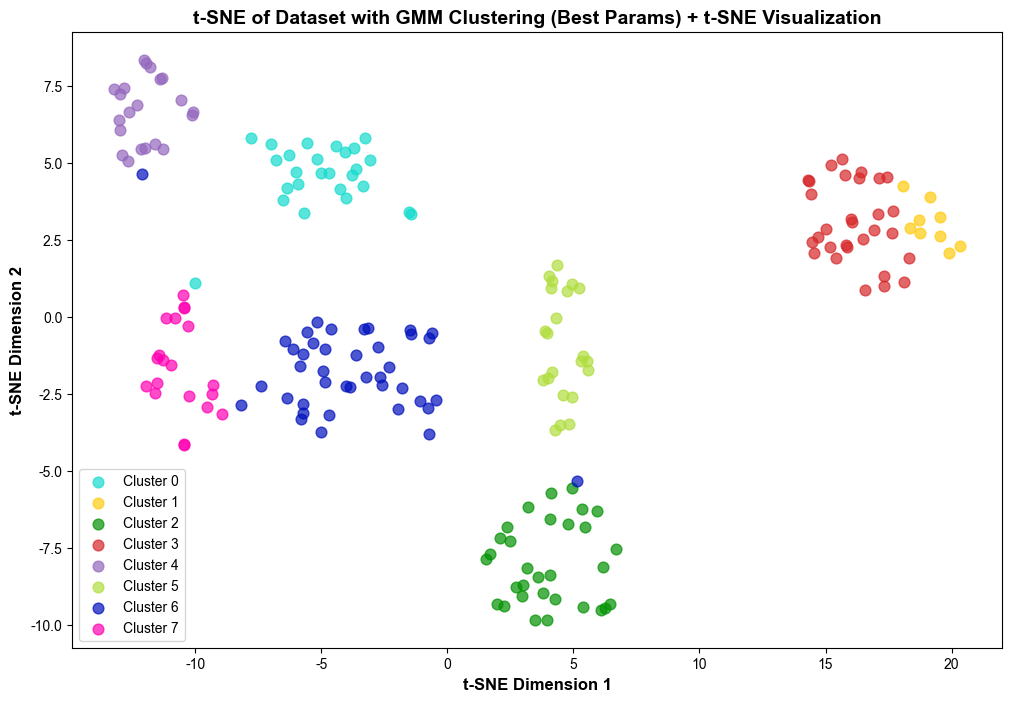

In [95]:
# 可视化最优超参组合的聚类结果
best_gmm = GaussianMixture(
    n_components=int(gmm_best_params_silhouette['n_components']),
    covariance_type=gmm_best_params_silhouette['covariance_type'],
    max_iter=int(gmm_best_params_silhouette['max_iter']),
    tol=gmm_best_params_silhouette['tol'],
    random_state=42,
    init_params='kmeans'
)
best_cluster_labels = best_gmm.fit_predict(data_gmm)
plt.figure(figsize=(12,8))

# t-SNE降维可视化
tsne = TSNE(n_components=2, random_state=42)
tsne_result_best_gmm = tsne.fit_transform(data_gmm)
data_gmm_vis = pd.DataFrame({
    'tsne-one': tsne_result_best_gmm[:,0],
    'tsne-two': tsne_result_best_gmm[:,1],
    'Cluster': best_cluster_labels
})
# 绘制样本点（按簇着色）
colors_gmm = ["#14dbce", "#ffcb0e", "#029202", '#d62728', '#9467bd', "#b0dd3d", "#0010BDF8", "#FF00B3", "#02ED02", "#FB6767", "#9C0F92"]  # 9簇配色，可扩展
for label in range(gmm_best_params_silhouette['n_components']):
    mask = data_gmm_vis['Cluster'] == label
    plt.scatter(
        data_gmm_vis.loc[mask, 'tsne-one'],
        data_gmm_vis.loc[mask, 'tsne-two'],
        c=colors_gmm[label],
        label=f'Cluster {label}',
        alpha=0.7,
        s=60
    )
plt.xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
plt.title('t-SNE of Dataset with GMM Clustering (Best Params) + t-SNE Visualization', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.show()

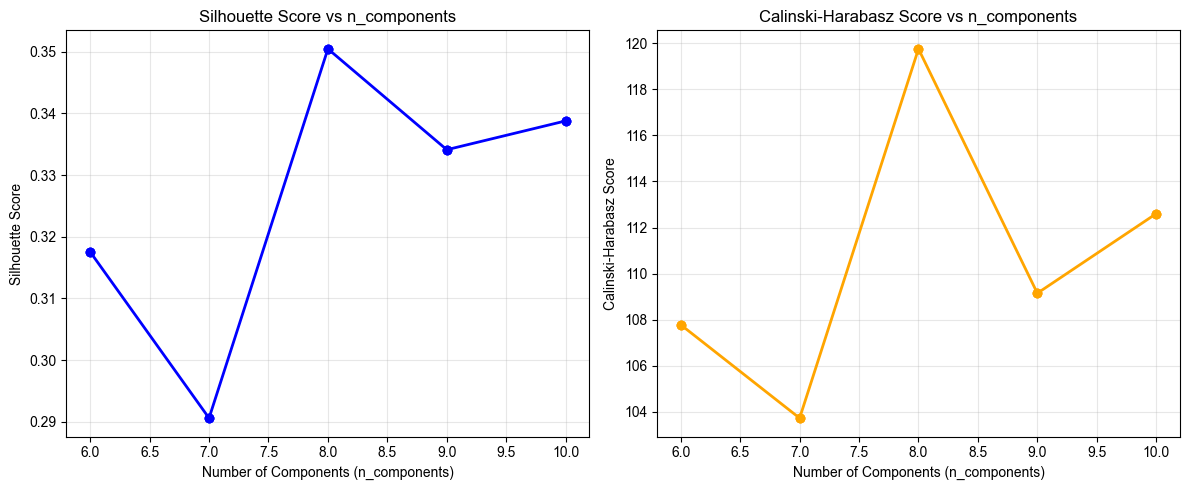

In [96]:
# 超参数对模型影响评估
# 1. n_components对评估指标的影响（固定其他最优超参）
best_cov = gmm_best_params_silhouette['covariance_type']
best_max_iter = gmm_best_params_silhouette['max_iter']
best_tol = gmm_best_params_silhouette['tol']

n_comp_results = results_df_gmm[
    (results_df_gmm['covariance_type'] == best_cov) &
    (results_df_gmm['max_iter'] == best_max_iter) &
    (results_df_gmm['tol'] == best_tol)
].sort_values('n_components')

plt.figure(figsize=(12, 5))

# 子图1：轮廓系数
plt.subplot(1, 2, 1)
plt.plot(n_comp_results['n_components'], n_comp_results['silhouette_score'], 'o-', color='blue', linewidth=2)
plt.xlabel('Number of Components (n_components)', fontsize=10)
plt.ylabel('Silhouette Score', fontsize=10)
plt.title('Silhouette Score vs n_components', fontsize=12)
plt.grid(alpha=0.3)

# 子图2：Calinski-Harabasz分数
plt.subplot(1, 2, 2)
plt.plot(n_comp_results['n_components'], n_comp_results['calinski_harabasz_score'], 'o-', color='orange', linewidth=2)
plt.xlabel('Number of Components (n_components)', fontsize=10)
plt.ylabel('Calinski-Harabasz Score', fontsize=10)
plt.title('Calinski-Harabasz Score vs n_components', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

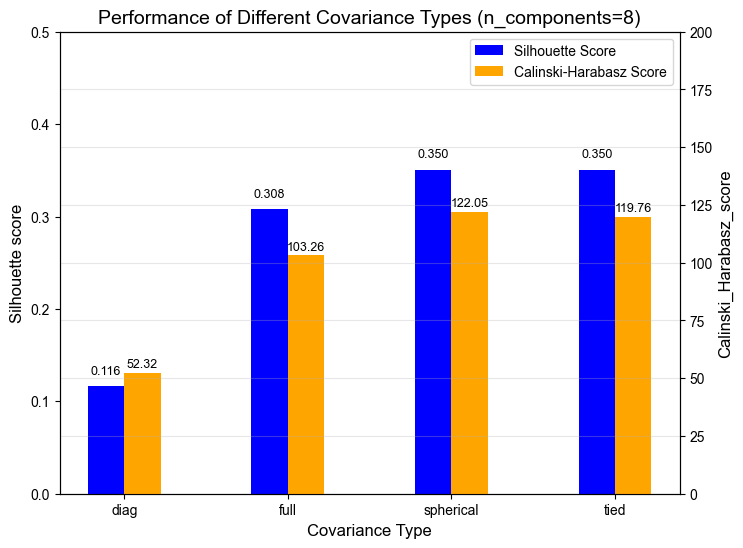

In [97]:
# 2. 不同covariance_type的性能对比（固定n_components为最优值）
n_comp_best = gmm_best_params_silhouette['n_components']
cov_results = results_df_gmm[
    (results_df_gmm['n_components'] == n_comp_best) &
    (results_df_gmm['max_iter'] == best_max_iter) &
    (results_df_gmm['tol'] == best_tol)
].groupby('covariance_type').agg({
    'silhouette_score': 'mean',
    'calinski_harabasz_score': 'mean'
}).reset_index()

# plt.figure(figsize=(10, 6))
fig, ax_gmm = plt.subplots(figsize=(8, 6))
ax_gmm_twin = ax_gmm.twinx()
width = 0.4; gap = 1.0
x = np.arange(len(cov_results['covariance_type'])) * (width*2 + gap)

# 归一化分数（便于同图展示）
# silhouette_norm = cov_results['silhouette_score'] / cov_results['silhouette_score'].max()
# chs_norm = cov_results['calinski_harabasz_score'] / cov_results['calinski_harabasz_score'].max()

# sil_bar = plt.bar(x - width/2, silhouette_norm, width, label='Normalized Silhouette Score', color='blue', alpha=0.7)
# chs_bar = plt.bar(x + width/2, chs_norm, width, label='Normalized Calinski-Harabasz Score', color='orange', alpha=0.7)
sil_bar = ax_gmm.bar(
    x - width/2, cov_results['silhouette_score'], 
    width, label='Silhouette Score', color='blue'
)
chs_bar = ax_gmm_twin.bar(
    x + width/2, cov_results['calinski_harabasz_score'], 
    width, label='Calinski-Harabasz Score', color='orange'
)
ax_gmm.set_xlabel('Covariance Type', fontsize=12)
ax_gmm.set_ylabel('Silhouette score', fontsize=12)
ax_gmm_twin.set_ylabel('Calinski_Harabasz_score', fontsize=12)
ax_gmm.set_title(f'Performance of Different Covariance Types (n_components={n_comp_best})', fontsize=14)
ax_gmm.set_xticks(x)
ax_gmm.set_xticklabels(cov_results['covariance_type'])
ax_gmm.set_ybound(upper=0.5)
ax_gmm_twin.set_ybound(upper=200)
for bar in sil_bar:
    h = bar.get_height()
    ax_gmm.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f'{h:.3f}', ha='center', va='bottom', fontsize=9)
    
for bar in chs_bar:
    h = bar.get_height()
    ax_gmm_twin.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                     f'{h:.2f}', ha='center', va='bottom', fontsize=9)

lines1, labels1 = ax_gmm.get_legend_handles_labels()
lines2, labels2 = ax_gmm_twin.get_legend_handles_labels()
ax_gmm.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='upper right')


# plt.xlabel('Covariance Type', fontsize=12)
# plt.ylabel('Normalized Score', fontsize=12)
# plt.title(f'Performance of Different Covariance Types (n_components={n_comp_best})', fontsize=14)
# plt.xticks(x, cov_results['covariance_type'])
# plt.legend()
# ax_gmm.legend(loc='upper right')
# ax_gmm_twin.legend(loc='upper left')
plt.grid(alpha=0.3, axis='y')
plt.show()

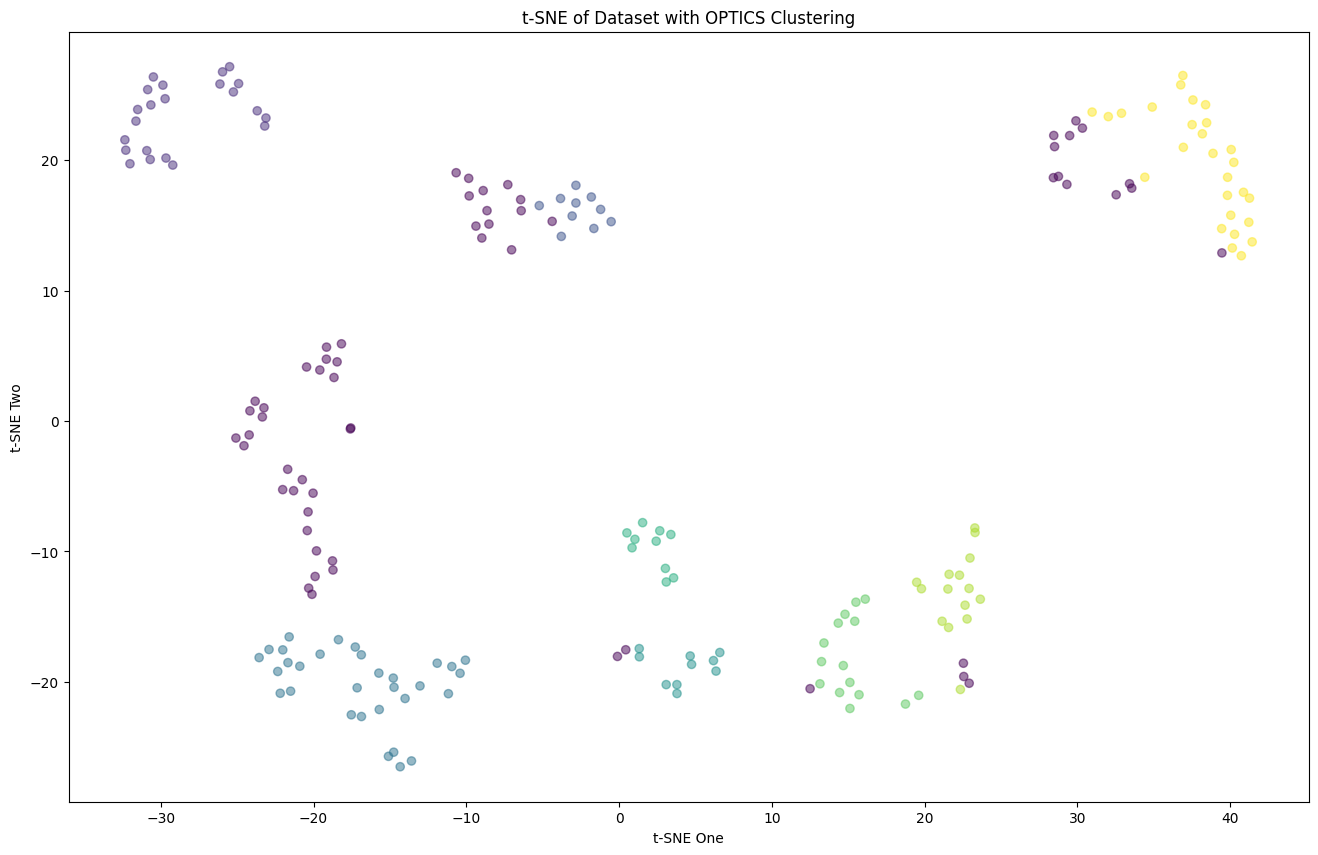

In [12]:
from sklearn.cluster import OPTICS
data_optics = df.copy() # already preprocessed
# apply clustering algorithm
optics = OPTICS(min_samples=10)
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_result_optics = tsne.fit_transform(data_optics)
data_optics['tsne-one'] = tsne_result_optics[:,0]
data_optics['tsne-two'] = tsne_result_optics[:,1]
data_optics['cluster'] = optics.fit_predict(data_optics[['tsne-one','tsne-two']])
plt.figure(figsize=(16,10))
plt.scatter(data_optics['tsne-one'], data_optics['tsne-two'], alpha=0.5, c=data_optics['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE of Dataset with OPTICS Clustering')
plt.show()

In [21]:
# # Evaluate K-Medoids
# kmedoids_scores = evaluate_clustering(data_kmedoids['kmedoids_cluster'].values, data_kmedoids.drop(columns=['tsne-one', 'tsne-two', 'kmedoids_cluster']))

# # Evaluate KMeans
# kmeans_scores = evaluate_clustering(data_kmeans['cluster'].values, data_kmeans.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

# # Evaluate HDBSCAN
# hdbscan_scores = evaluate_clustering(data_hdbscan['cluster'].values, data_hdbscan.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

# # Evaluate GMM
# gmm_scores = evaluate_clustering(data_gmm['cluster'].values, data_gmm.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

# # Evaluate OPTICS
# optics_scores = evaluate_clustering(data_optics['cluster'].values, data_optics.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

# print("K-Medoids Scores (Silhouette, Calinski-Harabasz):", kmedoids_scores)
# print("KMeans Scores (Silhouette, Calinski-Harabasz):", kmeans_scores)
# print("HDBSCAN Scores (Silhouette, Calinski-Harabasz):", hdbscan_scores)
# print("GMM Scores (Silhouette, Calinski-Harabasz):", gmm_scores)
# print("OPTICS Scores (Silhouette, Calinski-Harabasz):", optics_scores)